In [1]:
from __future__ import print_function
from __future__ import absolute_import

import os
import sys
import shutil
import tensorflow as tf
import scipy
from sklearn import metrics
import numpy as np

from matplotlib import pyplot as plt
from IPython import display

%matplotlib inline

In [2]:
# Import the Graph CNN model from the DLTK models
import graph_utils as utils
from dltk.core import modules
from dltk.models.graphical.cgcnn import CGCNN

# Set the CUDA_VISIBLE_DEVICES environmental variable to GPU ids to compute on
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

# Create a save path for log files and model parameters
save_path =  '/tmp/MNIST_graph_cnn'
shutil.rmtree(save_path, ignore_errors=True)
tf.logging.set_verbosity(tf.logging.ERROR)

# Load the MNIST data via tf.examples
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('../../data/MNIST_data', one_hot=False)

Extracting ../../data/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../../data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../../data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../../data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
# Graph parameters
coarsening_levels = 4
number_edges = 8
metric = 'euclidean'

# Network parameters
num_classes = max(mnist.train.labels) + 1  # number of classes

filters = [32, 64]
K_order = [25, 25]
strides = [4, 4]
num_fc = [512, num_classes]

In [4]:
def grid_graph(m, corners=False):
    ''' Create the regular image grid that is going to define the graph structure '''
    z = utils.grid(m)
    dist, idx = utils.distance_sklearn_metrics(z, k=number_edges, metric=metric)
    A = utils.adjacency(dist, idx)

    # Connections are only vertical or horizontal on the grid.
    # Corner vertices are connected to 2 neightbors only.
    if corners:
        import scipy.sparse
        A = A.toarray()
        A[A < A.max()/1.5] = 0
        A = scipy.sparse.csr_matrix(A)
        print('{} edges'.format(A.nnz))

    print("{} > {} edges".format(A.nnz//2, number_edges*m**2//2))
    return A

adjacency = grid_graph(28, corners=False)
adjacency = utils.replace_random_edges(adjacency, 0)
# Compute graphs and laplacians for each coarsening level
graphs, perm = utils.coarsen(adjacency, levels=coarsening_levels, self_connections=False)
laplacians = [utils.laplacian(adjacency, normalized=True) for adjacency in graphs]
del adjacency

3198 > 3136 edges
Layer 0: M_0 = |V| = 992 nodes (208 added),|E| = 3198 edges
Layer 1: M_1 = |V| = 496 nodes (85 added),|E| = 1433 edges
Layer 2: M_2 = |V| = 248 nodes (33 added),|E| = 670 edges
Layer 3: M_3 = |V| = 124 nodes (9 added),|E| = 330 edges
Layer 4: M_4 = |V| = 62 nodes (0 added),|E| = 164 edges


In [5]:
# Transform data to a GCN compatible format
train_data = mnist.train.images.astype(np.float32)

test_data = mnist.test.images.astype(np.float32)
test_data = utils.perm_data(test_data, perm)
test_labels = mnist.test.labels

# Build the GCNN network graph
net = CGCNN(laplacians, filters, K_order, strides, num_fc, bias='b1', pool='mpool', dropout=0.5)

# Create placeholders to feed input data during execution
batch_size = 100
M_0 = laplacians[0].shape[0]
xp = tf.placeholder(tf.float32, (100, M_0), 'data')
yp = tf.placeholder(tf.int32, (100), 'labels')

# Compute the mean categorical crossentropy as a loss function
logits_ = net(xp)['logits']
labels_ = yp
crossentropy_ = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_, labels=labels_)
# Cross-entropy loss
ce = tf.reduce_mean(crossentropy_, name='crossentropy')
# Add l2 regularisation to the FC layer
l2 = modules.l2_regularization(tf.get_collection(tf.GraphKeys.WEIGHTS, scope='fc_1'), 5e-4, name='l2')
loss_ = ce + l2

# Employ an Momentum optimiser to minimise the total loss during training
learning_rate = 0.02
momentum = 0.9
train_op = tf.train.MomentumOptimizer(learning_rate, momentum).minimize(loss_)

In [6]:
# Create additional ops to visualise the network output and track the training steps
y_hat_ = net(xp, is_training=False)['y_']
val_acc_ = tf.reduce_mean(tf.cast(tf.equal(tf.cast(yp, tf.int32), tf.cast(y_hat_, tf.int32)), tf.float32))
global_step = tf.Variable(0, name='global_step', trainable=False)

def predict(data, labels):
    acc = 0
    size = (data.shape[0])
    
    for begin in range(0, size, batch_size):
        end = begin + batch_size
        end = min([end, size])

        batch_data = np.zeros((batch_size, data.shape[1]))
        tmp_data = data[begin:end,:]
        if type(tmp_data) is not np.ndarray:
            tmp_data = tmp_data.toarray()  # convert sparse matrices
        batch_data[:end-begin] = tmp_data
        batch_labels = labels[begin:end]

        val_acc = s.run(val_acc_, {xp: batch_data, yp: batch_labels})
        acc += val_acc

    return acc * batch_size / size

In [7]:
# Set up a supervisor to continuously save and log the training progress, handle queues and initialise variables 
step = 0
loss_moving = []  
acc_moving = []  
sv = tf.train.Supervisor(logdir=save_path,
                         is_chief=True,
                         summary_op=None,
                         save_summaries_secs=30,
                         save_model_secs=60,
                         global_step=global_step)

s = sv.prepare_or_wait_for_session(config=tf.ConfigProto())

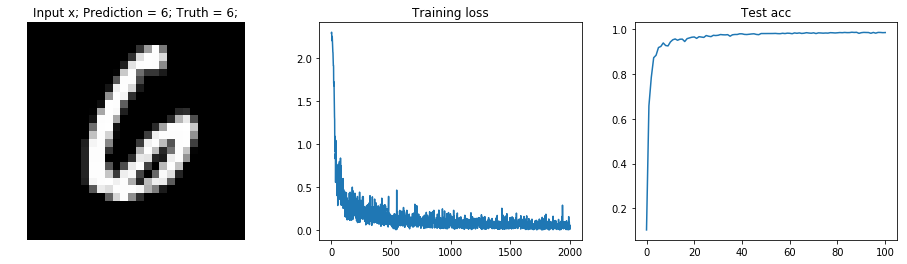

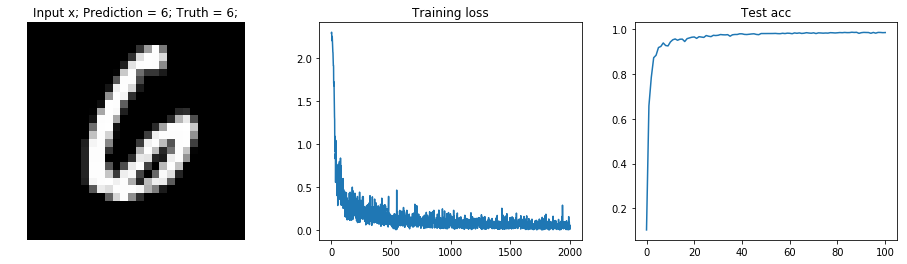

In [8]:
# Training loop  
while not step > 2000: # run for 20 epochs
    
    # Get a batch of training input pairs of x (image) and y (label)
    batch = mnist.train.next_batch(100)
    batch_data = utils.perm_data(batch[0], perm)
    batch_labels = batch[1]
    
    # Run the training op and the loss
    _, logits, loss = s.run([train_op, logits_, loss_], feed_dict={xp: batch_data, yp: batch_labels})
    loss_moving.append(loss)    
            
    # Visualise all inputs, outputs and losses during each training step
    if step % 20 == 0:
        
        # Compute the validation accuracy
        val_acc = predict(test_data, test_labels)
        acc_moving.append(val_acc)
    
        plt.close()
        f, axarr = plt.subplots(1, 3, figsize=(16,4))
        
        axarr[0].imshow(np.reshape(batch[0], [-1, 28, 28])[-1], cmap='gray', vmin=0, vmax=1)
        axarr[0].set_title('Input x; Prediction = {}; Truth = {};'.format(np.argmax(logits[-1,]), batch[1][-1,]))
        axarr[0].axis('off')
        
        axarr[1].plot(loss_moving)
        axarr[1].set_title('Training loss')
        axarr[1].axis('on')
        
        axarr[2].plot(acc_moving)
        axarr[2].set_title('Test acc')
        axarr[2].axis('on')

        display.clear_output(wait=True)
        display.display(plt.gcf())

    step += 1